# Figures for the book text

## R2 and ROC side by side

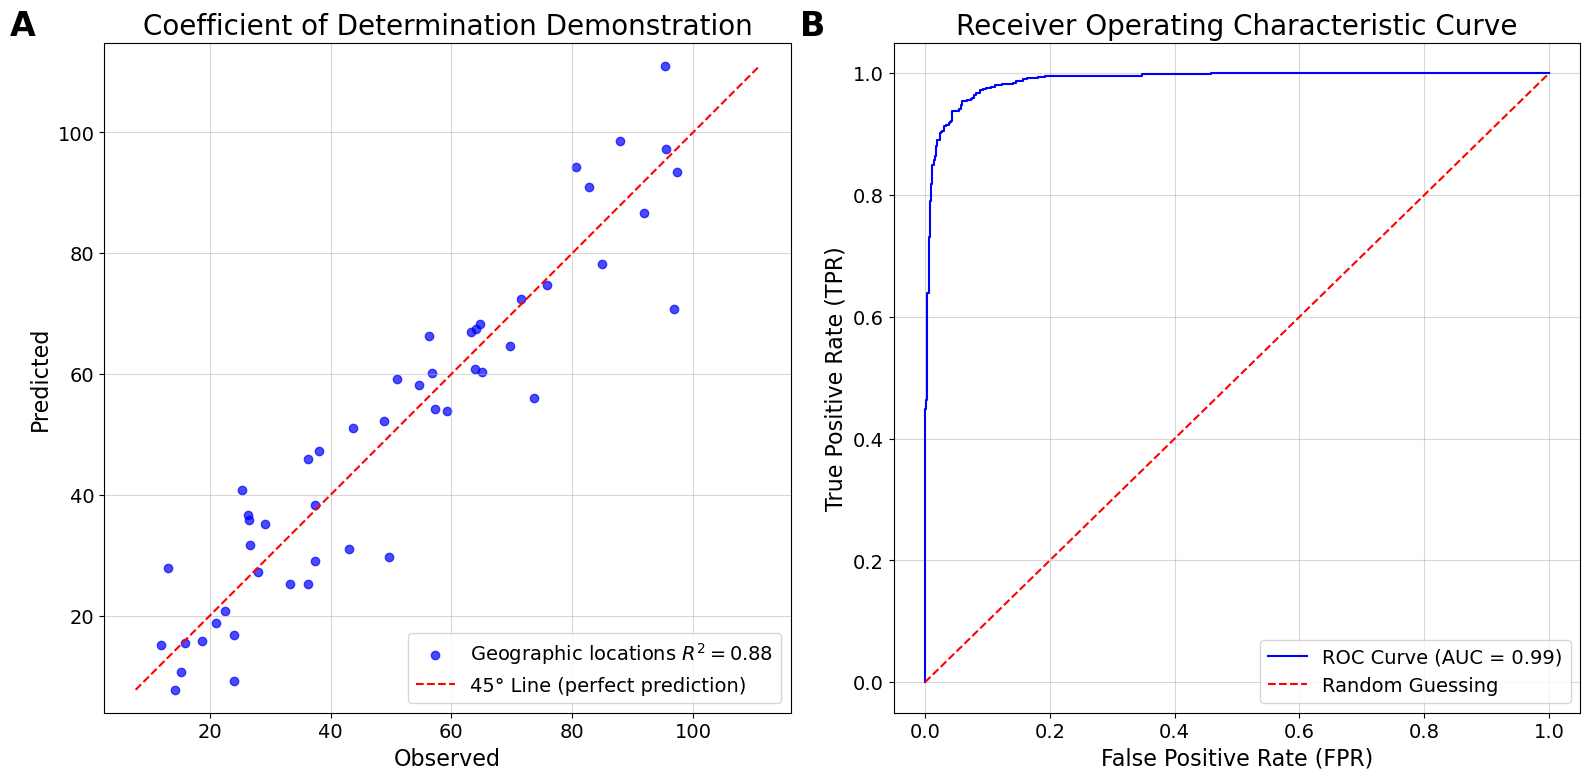

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, roc_curve, roc_auc_score

# Data for plot A
np.random.seed(42)
observed = np.random.uniform(10, 100, 50)
predicted = observed + np.random.normal(0, 10, 50)
r2 = r2_score(observed, predicted)
line = np.linspace(
    min(observed.min(), predicted.min()), max(observed.max(), predicted.max()), 100
)

# Data for plot B
y_true = np.random.randint(0, 2, 1000)
y_scores = np.where(
    y_true == 1, np.random.normal(0.7, 0.1, 1000), np.random.normal(0.4, 0.1, 1000)
)
y_scores = np.clip(y_scores, 0, 1)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# Define font sizes
title_fontsize = 20
label_fontsize = 16
tick_fontsize = 14
legend_fontsize = 14
subplot_label_fontsize = 24

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot A: R² Demonstration
axes[0].scatter(
    observed,
    predicted,
    color="blue",
    label=f"Geographic locations $R^2 = {r2:.2f}$",
    alpha=0.7,
)
axes[0].plot(
    line, line, color="red", linestyle="--", label="45° Line (perfect prediction)"
)
axes[0].set_xlabel("Observed", fontsize=label_fontsize)
axes[0].set_ylabel("Predicted", fontsize=label_fontsize)
axes[0].set_title("Coefficient of Determination Demonstration", fontsize=title_fontsize)
axes[0].legend(loc="lower right", fontsize=legend_fontsize)
axes[0].grid(alpha=0.5)
axes[0].axis("equal")

# Add subplot label 'A' to Plot A
axes[0].text(
    -0.1,
    1.05,
    "A",
    transform=axes[0].transAxes,
    fontsize=subplot_label_fontsize,
    fontweight="bold",
    va="top",
    ha="right",
)

# Increase tick label sizes for Plot A
axes[0].tick_params(axis="both", which="major", labelsize=tick_fontsize)

# Plot B: ROC Curve
axes[1].plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {auc:.2f})")
axes[1].plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Guessing")
axes[1].set_xlabel("False Positive Rate (FPR)", fontsize=label_fontsize)
axes[1].set_ylabel("True Positive Rate (TPR)", fontsize=label_fontsize)
axes[1].set_title("Receiver Operating Characteristic Curve", fontsize=title_fontsize)
axes[1].legend(fontsize=legend_fontsize)
axes[1].grid(alpha=0.5)

# Add subplot label 'B' to Plot B
axes[1].text(
    -0.1,
    1.05,
    "B",
    transform=axes[1].transAxes,
    fontsize=subplot_label_fontsize,
    fontweight="bold",
    va="top",
    ha="right",
)

# Increase tick label sizes for Plot B
axes[1].tick_params(axis="both", which="major", labelsize=tick_fontsize)

# Adjust layout and show the combined figure
plt.tight_layout()
# Save the figure to the 'images' folder
output_path = "../../images/R2_ROC_side_by_side_plots.png"
plt.savefig(output_path, dpi=300)
plt.show()

## Area of grid cells global

Number of grid cells created: 64800
Area range in square kilometers: 0.01 - 1.24
Natural Earth dataset already downloaded.
Extraction complete.


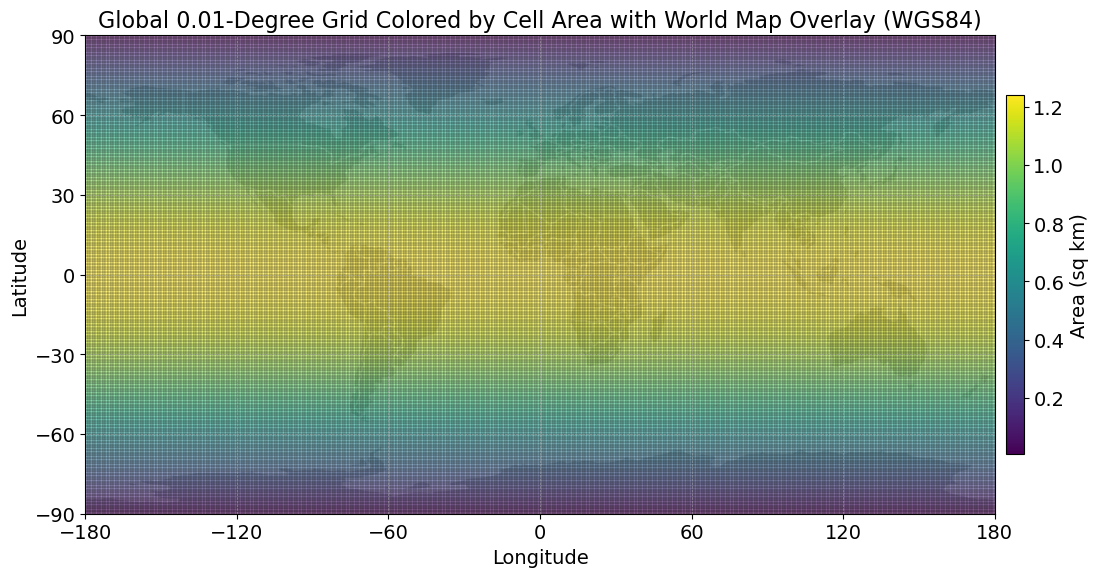

In [74]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np
import requests
import zipfile
import io
import os

# Make text larger
plt.rcParams.update(
    {
        "font.size": 14,  # Base font size
        "axes.titlesize": 16,  # Axes title size
        "axes.labelsize": 14,  # Axes label size
        "legend.fontsize": 14,  # Legend text size
        "xtick.labelsize": 14,  # X-axis tick label size
        "ytick.labelsize": 14,  # Y-axis tick label size
    }
)

# 1. Create a global 1-degree resolution grid in WGS84

# Define the range for longitude and latitude
lon_min, lon_max = -180, 180
lat_min, lat_max = -90, 90
resolution = 1  # degree

# Generate the list of longitude and latitude edges
lon_edges = np.arange(lon_min, lon_max, resolution)
lat_edges = np.arange(lat_min, lat_max, resolution)

# Create a list to hold all grid cell polygons
polygons = []
for lon in lon_edges:
    for lat in lat_edges:
        # Create a box for each grid cell
        polygons.append(box(lon, lat, lon + resolution, lat + resolution))

# Create a GeoDataFrame with WGS84 CRS
grid_wgs84 = gpd.GeoDataFrame({"geometry": polygons})
grid_wgs84.set_crs(epsg=4326, inplace=True)

print(f"Number of grid cells created: {len(grid_wgs84)}")

# 2. Reproject the grid to an equal-area projection for accurate area calculation

# Choose an equal-area CRS. Mollweide projection is suitable for global equal-area representation.
equal_area_crs = "ESRI:54009"

# Reproject the grid to the equal-area CRS
grid_equal_area = grid_wgs84.to_crs(equal_area_crs)

# 3. Calculate the area of each grid cell
grid_wgs84["area_sqm"] = grid_equal_area["geometry"].area
grid_wgs84["area_sqkm"] = grid_wgs84["area_sqm"] / (1e6 * 10_000)
print(
    f"Area range in square kilometers: {grid_wgs84['area_sqkm'].min():.2f} - {grid_wgs84['area_sqkm'].max():.2f}"
)

# 4. Overlay a basic world map for geographic context

# Since geopandas.datasets.get_path is deprecated, we'll manually download the 'naturalearth_lowres' dataset
naturalearth_url = (
    "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
)
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)
zip_path = os.path.join(data_dir, "ne_110m_admin_0_countries.zip")

# Download the dataset if it doesn't already exist
if not os.path.exists(zip_path):
    print("Downloading Natural Earth 'naturalearth_lowres' dataset...")
    response = requests.get(naturalearth_url)
    if response.status_code == 200:
        with open(zip_path, "wb") as f:
            f.write(response.content)
        print("Download complete.")
    else:
        raise Exception(f"Failed to download data. Status code: {response.status_code}")
else:
    print("Natural Earth dataset already downloaded.")

# Extract the zip file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(data_dir)
    print("Extraction complete.")

# Identify the extracted shapefile path
shapefile_path = os.path.join(data_dir, "ne_110m_admin_0_countries.shp")

# Load the world map using GeoPandas
world = gpd.read_file(shapefile_path)

# 5. Plot the WGS84 grid with cells colored by area and grid boundaries in thin black lines

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Reduce white space in the margins
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Plot the world map first
world.plot(ax=ax, color="lightgrey", edgecolor="white")

# Plot the grid on top
grid_wgs84.plot(
    column="area_sqkm",
    ax=ax,
    cmap="viridis",
    linewidth=0.25,  # Thin lines for grid boundaries
    edgecolor="black",
    alpha=0.6,  # Semi-transparent grid cells
    legend=True,
    legend_kwds={
        "label": "Area (sq km)",
        "orientation": "vertical",
        "shrink": 0.75,
        "pad": 0.01,
    },
)

ax.set_title(
    "Global 0.01-Degree Grid Colored by Cell Area with World Map Overlay (WGS84)"
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Customize grid ticks
ax.set_xticks(np.arange(-180, 181, 60))
ax.set_yticks(np.arange(-90, 91, 30))
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Let matplotlib automatically scale the axis
ax.set_aspect("auto")
ax.margins(0)

# Use tight_layout for a final nudge on spacing
plt.tight_layout()

# Save the figure
output_path = "../../images/global_1_degree_grid_wgs84_area.png"
plt.savefig(output_path, dpi=300)
plt.show()


## Pytorch RCF demo

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms
import numpy as np


class RCFWithPatchSampling(nn.Module):
    """
    A model for extracting Random Convolution Features (RCF) with patch sampling
    from the input image for empirical convolution kernels.
    """

    def __init__(
        self,
        num_features=6,  # Number of features to compute (must be divisible by 2)
        kernel_size=3,
        num_input_channels=3,
        patch_sampling=True,  # Enable empirical patch sampling
        seed=42,  # Seed for reproducibility
    ):
        super(RCFWithPatchSampling, self).__init__()
        # Set the seed for reproducibility
        torch.manual_seed(seed)

        assert num_features % 2 == 0, "num_features must be divisible by 2"
        self.num_features = num_features
        self.kernel_size = kernel_size
        self.patch_sampling = patch_sampling
        self.seed = seed

        if patch_sampling:
            self.register_buffer(
                "weights",
                torch.zeros(
                    num_features // 2,
                    num_input_channels,
                    kernel_size,
                    kernel_size,
                    requires_grad=False,
                ),
            )
            self.register_buffer(
                "biases", torch.zeros(num_features // 2, requires_grad=False) - 2
            )
        else:
            self.conv1 = nn.Conv2d(
                num_input_channels,
                num_features // 2,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,  # Ensure input shape is preserved
                bias=True,
            )
            nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0)
            nn.init.constant_(self.conv1.bias, -1.0)

    def extract_patches(self, img_tensor):
        """Extracts patches for empirical sampling."""
        _, c, h, w = img_tensor.shape
        np.random.seed(self.seed)
        for i in range(self.num_features // 2):
            y = np.random.randint(0, h - self.kernel_size)
            x = np.random.randint(0, w - self.kernel_size)
            patch = img_tensor[0, :, y : y + self.kernel_size, x : x + self.kernel_size]
            self.weights[i] = patch

    def forward(self, x):
        if self.patch_sampling:
            self.extract_patches(x)
            conv_output = F.conv2d(
                x, self.weights, bias=self.biases, stride=1, padding=0
            )
        else:
            conv_output = self.conv1(x)

        # Activation
        x1a = F.relu(conv_output, inplace=True)

        # Global average pooling
        x1a_pooled = F.adaptive_avg_pool2d(x1a, (1, 1)).squeeze()

        return x1a, conv_output

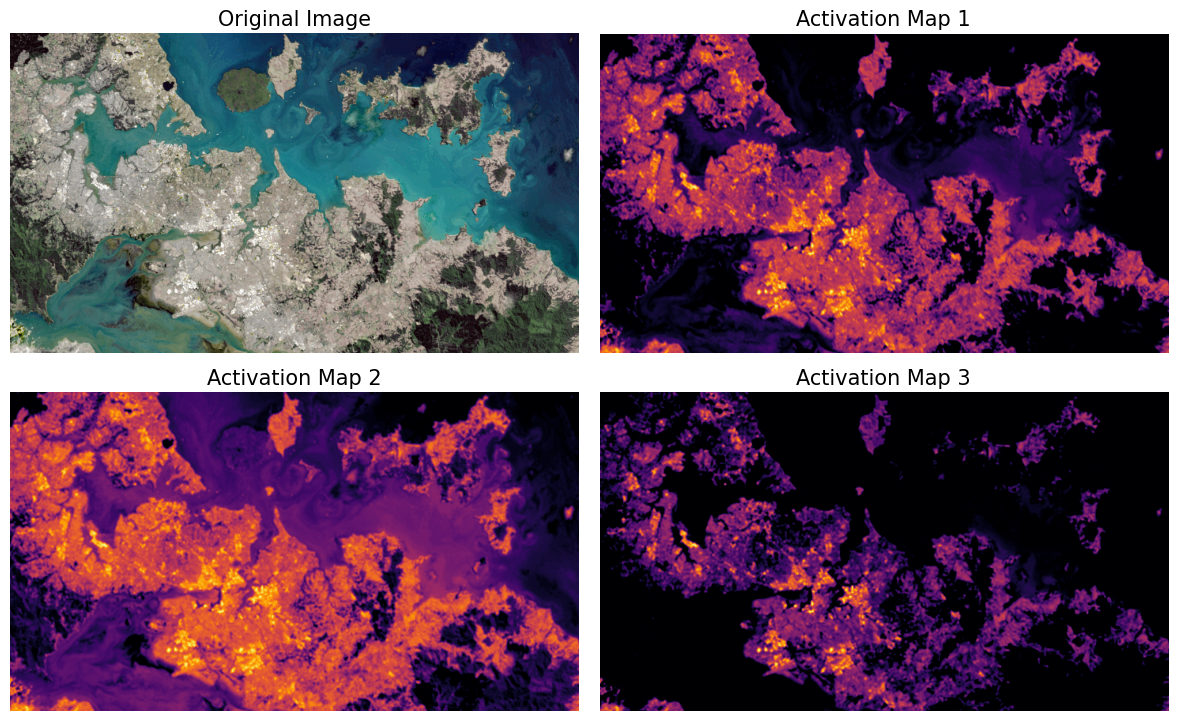

In [76]:
seed = 452

url = (
    "https://cdn.sanity.io/images/hvd5n54p/production/"
    "a332510258992b73c57a72177a391a331c91c951-945x531.jpg?"
    "w=1200&auto=format"
)

url = (
    "https://cdn.sanity.io/images/hvd5n54p/production/"
    "f7ebef7923c4cc9c8990836980a30d004a5eef64-1920x1114.jpg?"
    "w=1200&auto=format"
)

# url = ("https://cdn.sanity.io/images/hvd5n54p/production/395398de2fd43f81885f2be3d8187dcab1733c89-1224x693.jpg?w=1200&auto=format")

# url = "https://ai4edatasetspublicassets.blob.core.windows.net/assets/pc_thumbnails/sentinel-2.png"

url = "https://ai4edatasetspublicassets.blob.core.windows.net/assets/pc_thumbnails/landsat.png"

# url = "https://ai4edatasetspublicassets.blob.core.windows.net/assets/pc_thumbnails/cop-dem-glo-90.png"

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

# Convert the image to a tensor
transform = transforms.ToTensor()
img_tensor = transform(img).unsqueeze(0)

# Initialize the model
model = RCFWithPatchSampling(num_features=6, patch_sampling=True, seed=seed)

# Pass the image through the model
act_pos, conv_map = model(img_tensor)


# Plot results in a 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(12, 7.5))

# Original image
axs[0, 0].imshow(img)
axs[0, 0].set_title("Original Image", fontsize=15)
axs[0, 0].axis("off")

# Positive activation maps
color_maps = ["gray", "viridis", "inferno"]
vmin = act_pos.min()
vmax = act_pos.max()
for i in range(3):
    act_pos_vis = act_pos[0, i].detach().cpu().numpy()
    axs[(i + 1) // 2, (i + 1) % 2].imshow(
        act_pos_vis, cmap=color_maps[2]
    )  # , vmin=vmin, vmax=vmax)
    axs[(i + 1) // 2, (i + 1) % 2].set_title(f"Activation Map {i + 1}", fontsize=15)
    axs[(i + 1) // 2, (i + 1) % 2].axis("off")

plt.tight_layout()
plot_filename = "../../images/RCF_patch_sampling_activation_maps.png"
plt.savefig(plot_filename, dpi=300)
plt.show()


## World feature activation

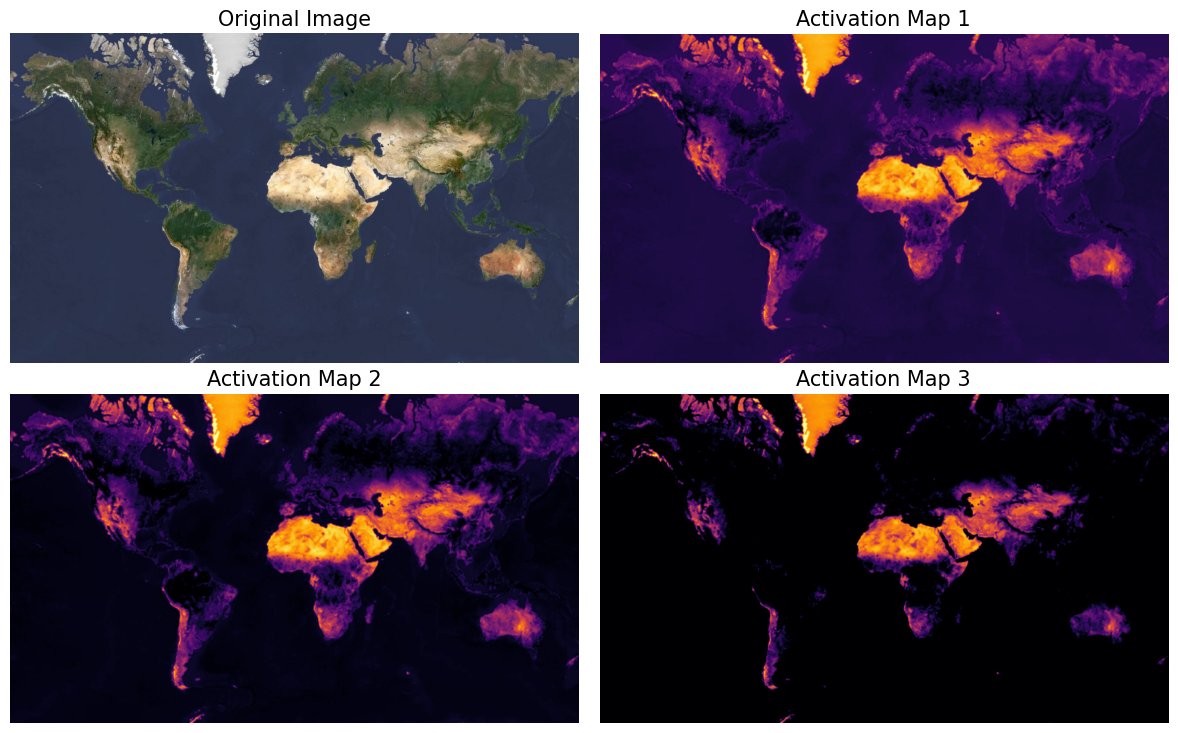

In [77]:
seed = 1

url = (
    "https://cdn.sanity.io/images/hvd5n54p/production/"
    "f7ebef7923c4cc9c8990836980a30d004a5eef64-1920x1114.jpg?"
    "w=1200&auto=format"
)

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

# Convert the image to a tensor
transform = transforms.ToTensor()
img_tensor = transform(img).unsqueeze(0)

# Initialize the model
model = RCFWithPatchSampling(num_features=6, patch_sampling=True, seed=seed)

# Pass the image through the model
act_pos, conv_map = model(img_tensor)


# Plot results in a 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(12, 7.5))

# Original image
axs[0, 0].imshow(img)
axs[0, 0].set_title("Original Image", fontsize=15)
axs[0, 0].axis("off")

# Positive activation maps
color_maps = ["gray", "viridis", "inferno"]
for i in range(3):
    act_pos_vis = act_pos[0, i].detach().cpu().numpy()
    axs[(i + 1) // 2, (i + 1) % 2].imshow(act_pos_vis, cmap=color_maps[2])
    axs[(i + 1) // 2, (i + 1) % 2].set_title(f"Activation Map {i + 1}", fontsize=15)
    axs[(i + 1) // 2, (i + 1) % 2].axis("off")

plt.tight_layout()
plot_filename = "../../images/RCF_patch_sampling_activation_maps_world.png"
plt.savefig(plot_filename, dpi=300)
plt.show()


In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from scipy.signal import convolve2d


def sharpen_image(image: np.ndarray) -> np.ndarray:
    # Define sharpening kernel
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

    # Apply kernel to each band if the image has more than 2 dimensions.
    if len(image.shape) == 3:
        sharpened = np.zeros_like(image)
        for i in range(image.shape[2]):
            sharpened[:, :, i] = convolve2d(
                image[:, :, i], kernel, mode="same", boundary="symm"
            )
    else:
        sharpened = convolve2d(image, kernel, mode="same", boundary="symm")

    return np.clip(sharpened, 0, 1)


class RCFWithPatchSampling(nn.Module):
    """
    A model for extracting Random Convolution Features (RCF) with patch sampling
    from the input image for empirical convolution kernels.
    """

    def __init__(
        self,
        num_features: int = 6,  # Number of features to compute (must be divisible by 2)
        kernel_size: int = 3,
        num_input_channels: int = 3,
        patch_sampling: bool = True,  # Enable empirical patch sampling
        seed: int = 42,  # Seed for reproducibility
        bias: float = -1.0,  # Bias value for the convolution layer
    ) -> None:
        super(RCFWithPatchSampling, self).__init__()
        # Set the seed for reproducibility
        torch.manual_seed(seed)

        assert num_features % 2 == 0, "num_features must be divisible by 2"
        self.num_features = num_features
        self.kernel_size = kernel_size
        self.num_input_channels = num_input_channels
        self.patch_sampling = patch_sampling
        self.seed = seed
        self.bias = bias

        # Will store coordinates (y, x) for each patch so that we can plot them later
        self.patch_coords = []
        self.unnormalized_patches = None

        if patch_sampling:
            # We register the weight and bias tensors as "buffers". This does two things:
            # makes them behave correctly when we call .to(...) on the module, and makes
            # them explicitly _not_ Parameters of the model (which might get updated) if
            # a user tries to train with this model.
            self.register_buffer(
                "weights",
                torch.zeros(
                    num_features // 2,
                    num_input_channels,
                    kernel_size,
                    kernel_size,
                    requires_grad=False,
                ),
            )
            self.register_buffer(
                "biases", torch.zeros(num_features // 2, requires_grad=False) - bias
            )
        else:
            self.conv1 = nn.Conv2d(
                num_input_channels,
                num_features // 2,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,  # Ensure input shape is preserved
                bias=True,
            )
            nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0)
            nn.init.constant_(self.conv1.bias, -1.0)

    def extract_patches(self, img_tensor: torch.Tensor) -> None:
        """
        Extract patches for empirical sampling and store their locations.

        Parameters
        ----------
        img_tensor : torch.Tensor
            The input tensor with shape [B, C, H, W]. Note: We use only the first image.
        """
        _, c, h, w = img_tensor.shape
        np.random.seed(self.seed)
        patches = np.zeros(
            (
                self.num_features // 2,
                self.num_input_channels,
                self.kernel_size,
                self.kernel_size,
            ),
            dtype=np.float32,
        )
        self.patch_coords = []  # Reset coordinates on every call

        for i in range(self.num_features // 2):
            # Ensure that the sampled patch fully fits in the image dimensions.
            y = np.random.randint(0, h - self.kernel_size + 1)
            x = np.random.randint(0, w - self.kernel_size + 1)
            self.patch_coords.append((y, x))

            # Convert the patch to NumPy float32 explicitly
            patch = (
                img_tensor[0, :, y : y + self.kernel_size, x : x + self.kernel_size]
                .detach()
                .cpu()
                .numpy()
                .astype(np.float32)
            )
            patches[i] = patch

        # Keep a copy of the unnormalized patches
        unnorm_patches = np.copy(patches)

        # Normalize them
        patches = self._normalize(patches)

        # Convert both unnormalized and normalized patches to torch Tensors
        self.unnormalized_patches = torch.tensor(unnorm_patches)
        self.weights = torch.tensor(patches)

    def _normalize(
        self,
        patches: "np.typing.NDArray[np.float32]",
        min_divisor: float = 1e-8,
        zca_bias: float = 0.001,
    ) -> "np.typing.NDArray[np.float32]":
        n_patches = patches.shape[0]
        orig_shape = patches.shape
        patches = patches.reshape(n_patches, -1)

        # Zero-mean
        patches = patches - np.mean(patches, axis=1, keepdims=True)

        # Normalize
        patch_norms = np.linalg.norm(patches, axis=1)
        patch_norms[np.where(patch_norms < min_divisor)] = 1
        patches = patches / patch_norms[:, np.newaxis]

        # ZCA
        patches_cov_mat = (1.0 / n_patches) * patches.T.dot(patches)
        E, V = np.linalg.eig(patches_cov_mat)
        E += zca_bias
        sqrt_zca_eigs = np.sqrt(E)
        inv_sqrt_zca_eigs = np.diag(np.power(sqrt_zca_eigs, -1))
        global_zca = V.dot(inv_sqrt_zca_eigs).dot(V.T)

        patches_normalized = patches.dot(global_zca).dot(global_zca.T)

        # Return in original shape but let PyTorch do the float32 conversion
        return patches_normalized.reshape(orig_shape)

    def forward(self, x: torch.Tensor):
        if self.patch_sampling:
            self.extract_patches(x)
            conv_output = F.conv2d(
                x,
                self.weights,
                bias=self.biases,
                stride=1,
                padding=0,
            )
        else:
            conv_output = self.conv1(x)
        conv_output_pre_relu = conv_output.clone().detach()
        # Activation
        x1a = F.relu(conv_output)

        # Global average pooling
        x1a_pooled = F.adaptive_avg_pool2d(x1a, (1, 1)).squeeze()

        # Return unnormalized patches in addition to the other outputs if patch_sampling
        if self.patch_sampling:
            return x1a, conv_output, x1a_pooled, self.unnormalized_patches
        else:
            return x1a, conv_output_pre_relu, x1a_pooled, None


In [79]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import rasterio

In [94]:
# seed = 0
# url = (
#     "https://cdn.sanity.io/images/hvd5n54p/production/"
#     "a332510258992b73c57a72177a391a331c91c951-945x531.jpg?"
#     "w=1200&auto=format"
# )

# response = requests.get(url)
# img = Image.open(BytesIO(response.content)).convert("RGB")

# transform = transforms.ToTensor()
# img_tensor = transform(img).unsqueeze(0)

# # Initialize the model
# model = RCFWithPatchSampling(
#     num_features=6, patch_sampling=True, seed=seed, kernel_size=6, bias=-1.0
# )

# # Pass the image through the model
# act_pos, conv_map, feats, un_norm_patches = model(img_tensor)

# patch_array = un_norm_patches.cpu().numpy()
# patch_coords = model.patch_coords

# norm_patch_array = model.weights.cpu().numpy()

# min_val = norm_patch_array.min()
# max_val = norm_patch_array.max()
# # Avoid division by zero if the array is constant
# if max_val - min_val < 1e-12:
#     norm_patch_array = np.zeros_like(norm_patch_array)
# else:
#     norm_patch_array = (norm_patch_array - min_val) / (max_val - min_val)

# act_maps = conv_map[0, :3].detach().cpu().numpy()
# colors = ["#D81B60", "#1E88E5", "#2EB62F"]

# ###############################################################################
# # Create a figure with 4 rows and 3 columns.
# # Row 1: Original image
# # Row 2: Patch 1, Whitened Patch 1, Activation Map 1
# # Row 3: Patch 2, Whitened Patch 2, Activation Map 2
# # Row 4: Patch 3, Whitened Patch 3, Activation Map 3
# ###############################################################################
# fig = plt.figure(figsize=(16, 22))
# gs = gridspec.GridSpec(
#     4,
#     3,
#     height_ratios=[3.5, 1.1, 1.1, 1.1],
#     hspace=0.1,
#     wspace=0.0,
#     width_ratios=[1, 1, 1.5],
# )

# ###############################################################################
# # Row 1: Original Image (spanning all 3 columns)
# ###############################################################################
# ax0 = fig.add_subplot(gs[0, :])
# ax0.imshow(img)
# ax0.set_title("Input Image", fontsize=20)
# ax0.axis("off")

# # Annotate with rectangles where patches are taken
# for color, (y, x) in zip(colors, patch_coords):
#     rect = mpatches.Rectangle(
#         (x, y),
#         model.kernel_size,
#         model.kernel_size,
#         linewidth=2,
#         edgecolor=color,
#         facecolor="none",
#     )
#     ax0.add_patch(rect)
#     ax0.plot(
#         x,
#         y,
#         marker="o",
#         color=color,
#         markersize=50,
#         markerfacecolor="None",
#         markeredgewidth=5,
#     )

# ###############################################################################
# # Rows 2-4: Each row has (Patch i, Whitened Patch i, Activation Map i)
# ###############################################################################
# for i in range(3):
#     # Patch
#     ax_patch = fig.add_subplot(gs[i + 1, 0])
#     patch_img = patch_array[i].transpose(1, 2, 0)  # (C,H,W) -> (H,W,C)
#     ax_patch.imshow(patch_img, interpolation="nearest")
#     ax_patch.set_title(f"Patch {i + 1}", fontsize=14, color=colors[i])
#     ax_patch.axis("off")

#     # Whitened Patch
#     ax_patch_norm = fig.add_subplot(gs[i + 1, 1])
#     patch_img_norm = norm_patch_array[i].transpose(1, 2, 0)  # (C,H,W)->(H,W,C)
#     ax_patch_norm.imshow(patch_img_norm, interpolation="nearest")
#     ax_patch_norm.set_title(f"Whitened Patch {i + 1}", fontsize=14, color=colors[i])
#     ax_patch_norm.axis("off")

#     # Activation Map
#     ax_act = fig.add_subplot(gs[i + 1, 2])
#     ax_act.imshow(act_maps[i], cmap="magma")
#     ax_act.set_title(f"Convolution Map {i + 1}", fontsize=14, color=colors[i])
#     ax_act.axis("off")

# fig_fp = "../../images/RCF_patch_sampling_convolution_maps_patches.png"
# plt.savefig(fig_fp, dpi=300, bbox_inches="tight", pad_inches=0.1)
# plt.show()


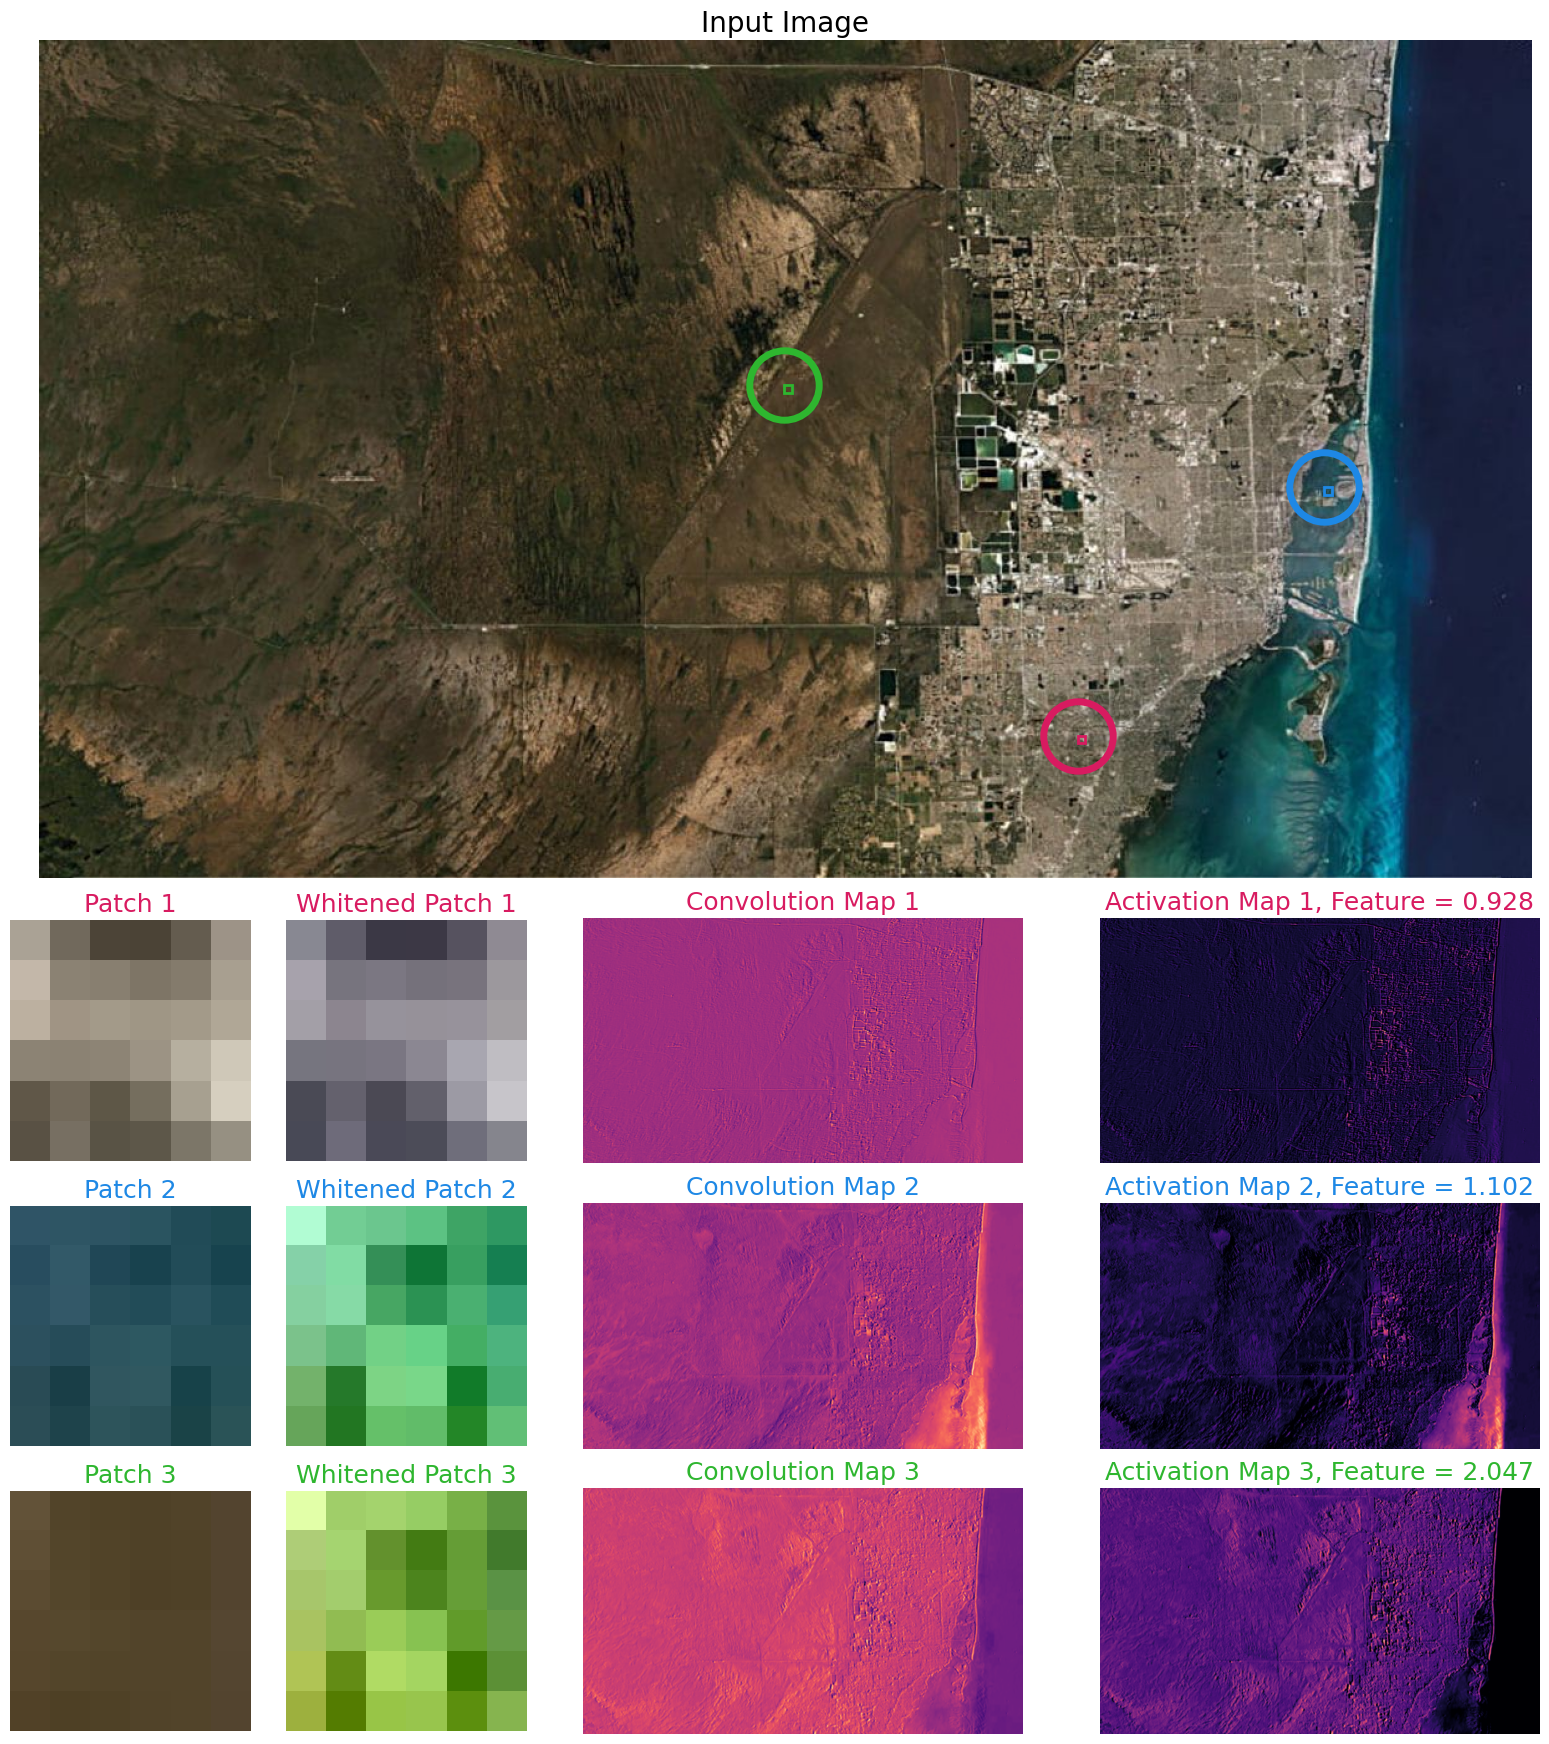

In [95]:
seed = 0
url = (
    "https://cdn.sanity.io/images/hvd5n54p/production/"
    "a332510258992b73c57a72177a391a331c91c951-945x531.jpg?"
    "w=1200&auto=format"
)

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

transform = transforms.ToTensor()
img_tensor = transform(img).unsqueeze(0)

# Initialize the model
model = RCFWithPatchSampling(
    num_features=6, patch_sampling=True, seed=seed, kernel_size=6, bias=-1.0
)

# Pass the image through the model
#
x1a, conv_map, feats, un_norm_patches = model(img_tensor)

patch_array = un_norm_patches.cpu().numpy()
patch_coords = model.patch_coords

norm_patch_array = model.weights.cpu().numpy()

# Normalize for display (whitened patches)
min_val = norm_patch_array.min()
max_val = norm_patch_array.max()
if max_val - min_val < 1e-12:
    norm_patch_array = np.zeros_like(norm_patch_array)
else:
    norm_patch_array = (norm_patch_array - min_val) / (max_val - min_val)

# Get the first 3 raw convolution maps and first 3 post-ReLU activation maps
conv_maps = conv_map[0, :3].detach().cpu().numpy()
act_maps = x1a[0, :3].detach().cpu().numpy()

colors = ["#D81B60", "#1E88E5", "#2EB62F"]

###############################################################################
# Create a figure with 4 rows and 4 columns.
# Row 1: Original image (spanning all 4 columns)
# Row 2: Patch 1, Whitened Patch 1, Convolution Map 1, Activation Map 1
# Row 3: Patch 2, Whitened Patch 2, Convolution Map 2, Activation Map 2
# Row 4: Patch 3, Whitened Patch 3, Convolution Map 3, Activation Map 3
###############################################################################
fig = plt.figure(figsize=(20, 22))
gs = gridspec.GridSpec(
    4,
    4,
    height_ratios=[3.75, 1.1, 1.1, 1.1],
    width_ratios=[0.5, 0.5, 1, 1],
    hspace=0.1,
    wspace=0.1,
)

###############################################################################
# Row 1: Original Image (spanning all 4 columns)
###############################################################################
ax0 = fig.add_subplot(gs[0, :])
ax0.imshow(img)
ax0.set_title("Input Image", fontsize=20)
ax0.axis("off")

# Annotate with rectangles where patches are taken
for color, (y, x) in zip(colors, patch_coords):
    rect = mpatches.Rectangle(
        (x, y),
        model.kernel_size,
        model.kernel_size,
        linewidth=2,
        edgecolor=color,
        facecolor="none",
    )
    ax0.add_patch(rect)
    ax0.plot(
        x,
        y,
        marker="o",
        color=color,
        markersize=50,
        markerfacecolor="None",
        markeredgewidth=5,
    )

###############################################################################
# Rows 2-4: Each row has (Patch i, Whitened Patch i, Convolution Map i, Activation Map i)
###############################################################################
for i in range(3):
    # ---- Patch ----
    ax_patch = fig.add_subplot(gs[i + 1, 0])
    patch_img = patch_array[i].transpose(1, 2, 0)  # (C,H,W) -> (H,W,C)
    ax_patch.imshow(patch_img, interpolation="nearest")
    ax_patch.set_title(f"Patch {i + 1}", fontsize=18, color=colors[i])
    ax_patch.axis("off")

    # ---- Whitened Patch ----
    ax_patch_norm = fig.add_subplot(gs[i + 1, 1])
    patch_img_norm = norm_patch_array[i].transpose(1, 2, 0)  # (C,H,W)->(H,W,C)
    ax_patch_norm.imshow(patch_img_norm, interpolation="nearest")
    ax_patch_norm.set_title(f"Whitened Patch {i + 1}", fontsize=18, color=colors[i])
    ax_patch_norm.axis("off")

    # ---- Raw Convolution Map ----
    ax_conv = fig.add_subplot(gs[i + 1, 2])
    ax_conv.imshow(conv_maps[i], cmap="magma")
    ax_conv.set_title(f"Convolution Map {i + 1}", fontsize=18, color=colors[i])
    ax_conv.axis("off")

    # ---- Activation Map (after ReLU) ----
    ax_act = fig.add_subplot(gs[i + 1, 3])
    ax_act.imshow(act_maps[i], cmap="magma")
    ax_act.set_title(
        f"Activation Map {i + 1}, Feature = {feats.cpu().numpy()[i]:.3f}",
        fontsize=18,
        color=colors[i],
    )
    ax_act.axis("off")

fig_fp = "../../images/RCF_patch_sampling_convolution_activation_maps.png"
plt.savefig(fig_fp, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()


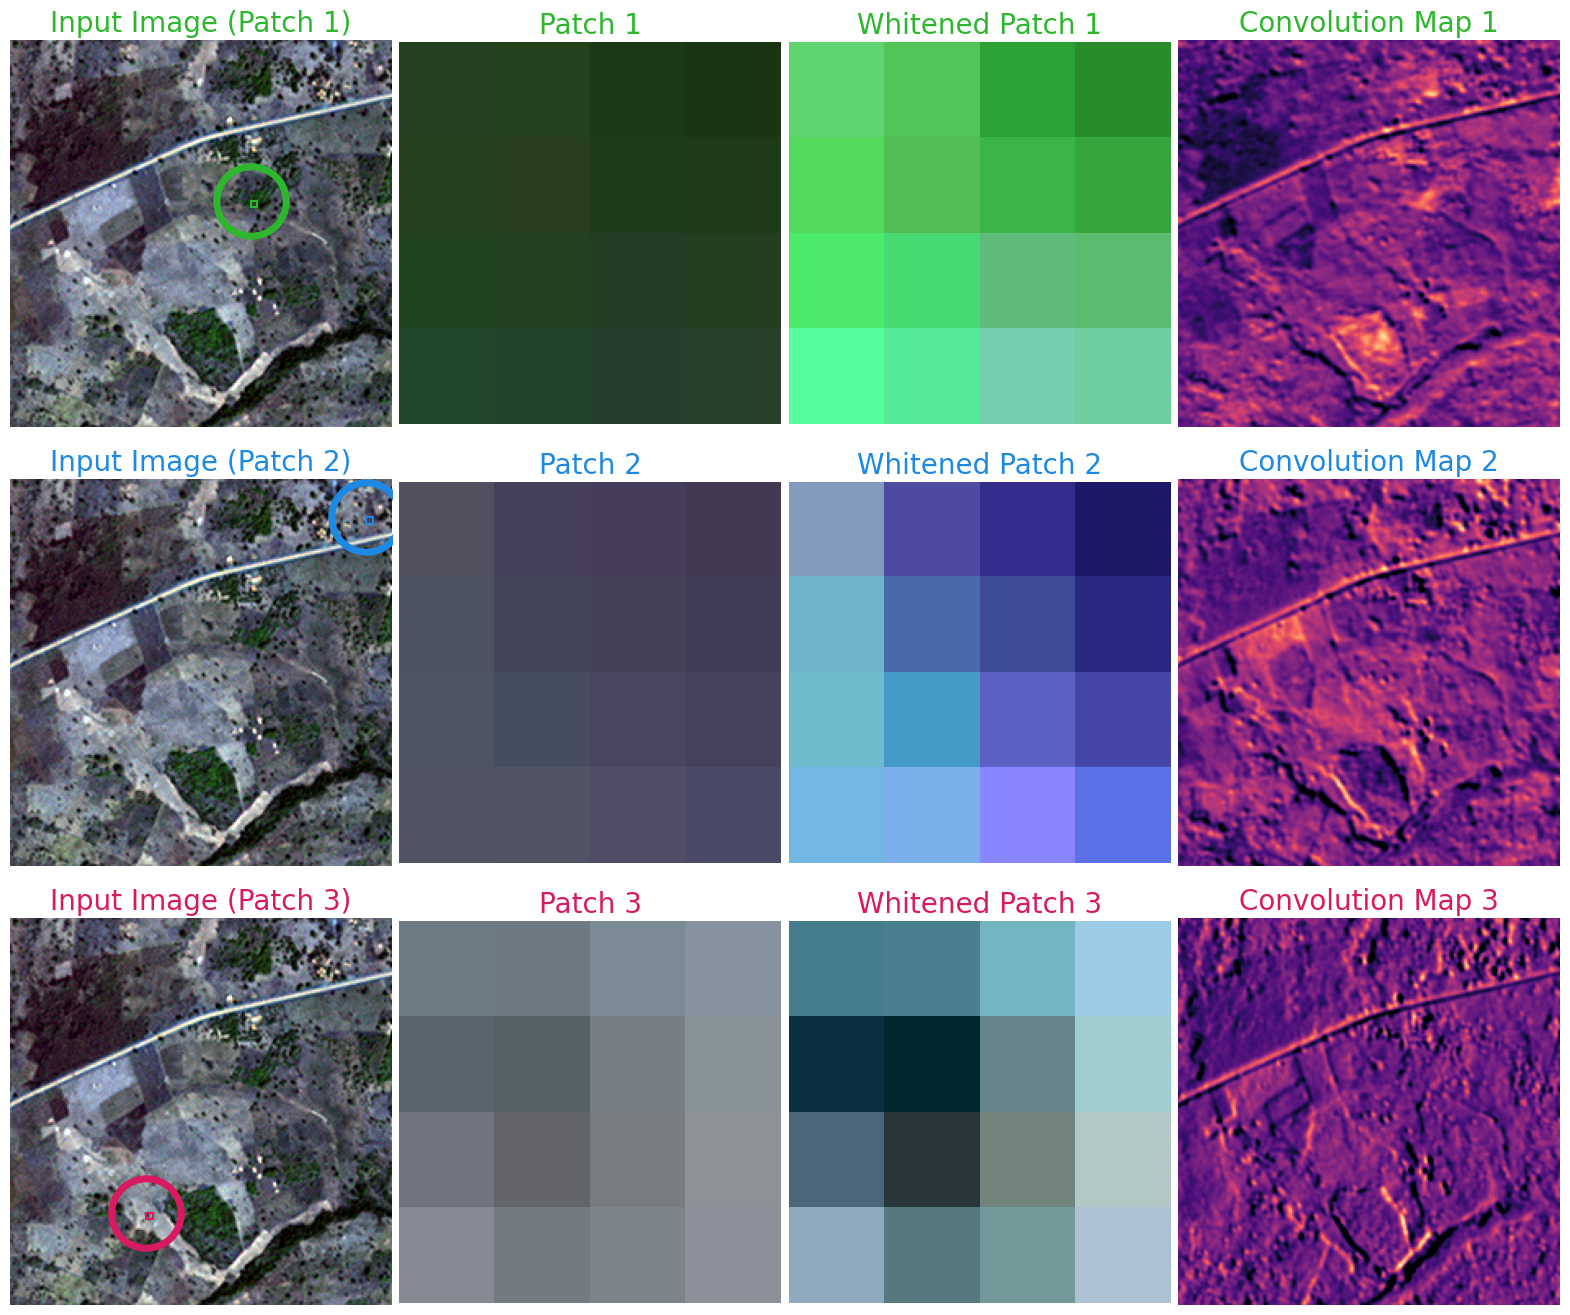

In [58]:
seed = 457
image_dir = (
    "../demo/basemaps/planet_medres_normalized_analytic_2024-12_mosaic/clipped_images"
)
image_list = os.listdir(image_dir)

# image = str(np.random.choice(image_list))
image = "lon_1.255__lat_8.955.tif"

image_path = os.path.join(image_dir, image)

with rasterio.open(image_path) as src:
    band1 = src.read(1)  # Red
    band2 = src.read(2)  # Green
    band3 = src.read(3)  # Blue

    # Normalize each band independently
    norm_band1 = (band1 - band1.min()) / (band1.max() - band1.min())
    norm_band2 = (band2 - band2.min()) / (band2.max() - band2.min())
    norm_band3 = (band3 - band3.min()) / (band3.max() - band3.min())
    rgb = np.dstack((norm_band1, norm_band2, norm_band3))
    float_rgb = rgb.astype(np.float32)
    rgb_sharpened = sharpen_image(float_rgb)

transform = transforms.ToTensor()
img_tensor = transform(float_rgb).unsqueeze(0)

model = RCFWithPatchSampling(
    num_features=6, patch_sampling=True, seed=seed, kernel_size=4, bias=-1.0
)

# Pass the image through the model
act_pos, conv_map, feats, un_norm_patches = model(img_tensor)

patch_array = un_norm_patches.cpu().numpy()
patch_coords = model.patch_coords

norm_patch_array = model.weights.cpu().numpy()

min_val = norm_patch_array.min()
max_val = norm_patch_array.max()

# Avoid division by zero if the array is constant
if max_val - min_val < 1e-12:
    norm_patch_array = np.zeros_like(norm_patch_array)
else:
    norm_patch_array = (norm_patch_array - min_val) / (max_val - min_val)

act_maps = conv_map[0, :3].detach().cpu().numpy()
colors = ["#2EB62F", "#1E88E5", "#D81B60"]


fig = plt.figure(figsize=(20, 17))
gs = gridspec.GridSpec(
    3,
    4,  # 3 rows (one for each patch), 4 columns
    wspace=0.02,
    hspace=0.02,
)

for i in range(3):
    # (a) Input image with only patch i highlighted (column 0)
    ax_img = fig.add_subplot(gs[i, 0])
    ax_img.imshow(rgb_sharpened)
    ax_img.axis("off")
    ax_img.set_title(f"Input Image (Patch {i + 1})", fontsize=20, color=colors[i])

    # Highlight only this patch i
    y, x = patch_coords[i]
    rect = mpatches.Rectangle(
        (x, y),
        model.kernel_size,
        model.kernel_size,
        linewidth=1.5,
        edgecolor=colors[i],
        facecolor="none",
    )
    ax_img.add_patch(rect)
    ax_img.plot(
        x,
        y,
        marker="o",
        color=colors[i],
        markersize=50,
        markerfacecolor="None",
        markeredgewidth=5,
    )

    # (b) Patch i (column 1)
    ax_patch = fig.add_subplot(gs[i, 1])
    patch_img = patch_array[i].transpose(1, 2, 0)  # (C,H,W) -> (H,W,C)
    ax_patch.imshow(patch_img, interpolation="nearest")
    ax_patch.set_title(f"Patch {i + 1}", fontsize=20, color=colors[i])
    ax_patch.axis("off")

    # (c) Whitened Patch i (column 2)
    ax_patch_norm = fig.add_subplot(gs[i, 2])
    patch_img_norm = norm_patch_array[i].transpose(1, 2, 0)  # (C,H,W)->(H,W,C)
    ax_patch_norm.imshow(patch_img_norm, interpolation="nearest")
    ax_patch_norm.set_title(f"Whitened Patch {i + 1}", fontsize=20, color=colors[i])
    ax_patch_norm.axis("off")

    # (d) Activation Map i (column 3)
    ax_act = fig.add_subplot(gs[i, 3])
    ax_act.imshow(act_maps[i], cmap="magma")
    ax_act.set_title(f"Convolution Map {i + 1}", fontsize=20, color=colors[i])
    ax_act.axis("off")

fig_fp = "../../images/RCF_nicfi_patches_convolution_maps.png"
plt.savefig(fig_fp, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()


## Pixel distribution

In [2]:
import os
import rasterio
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd


base_dir = "/Users/cullenmolitor/Documents/github/MOSAIKS-Training-Manual/notebooks/demo/basemaps"

mosaic_name = "planet_medres_normalized_analytic_2024-12_mosaic"

clipped_images_dir = os.path.join(base_dir, mosaic_name, "clipped_images")


shapes = []

directory = os.path.join(clipped_images_dir)
tif_files = glob.glob(os.path.join(directory, "*.tif"))

for tif_file in tqdm(tif_files, desc="Image chips", unit="file"):
    with rasterio.open(tif_file) as src:
        height = src.height
        width = src.width

        # Read only first 4 bands
        data = src.read(list(range(1, 5)))  # Bands 1-4

        stats = {}
        # Calculate statistics for each band
        for band_idx in range(4):  # Only process 4 bands
            band_data = data[band_idx]
            stats[f"band_{band_idx + 1}_min"] = float(np.min(band_data))
            stats[f"band_{band_idx + 1}_max"] = float(np.max(band_data))
            stats[f"band_{band_idx + 1}_mean"] = float(np.mean(band_data))
            stats[f"band_{band_idx + 1}_median"] = float(np.median(band_data))

    filename = os.path.splitext(os.path.basename(tif_file))[0]
    shapes.append({"filename": filename, "h": height, "w": width, **stats})

Image chips: 100%|██████████| 46599/46599 [02:19<00:00, 333.06file/s]


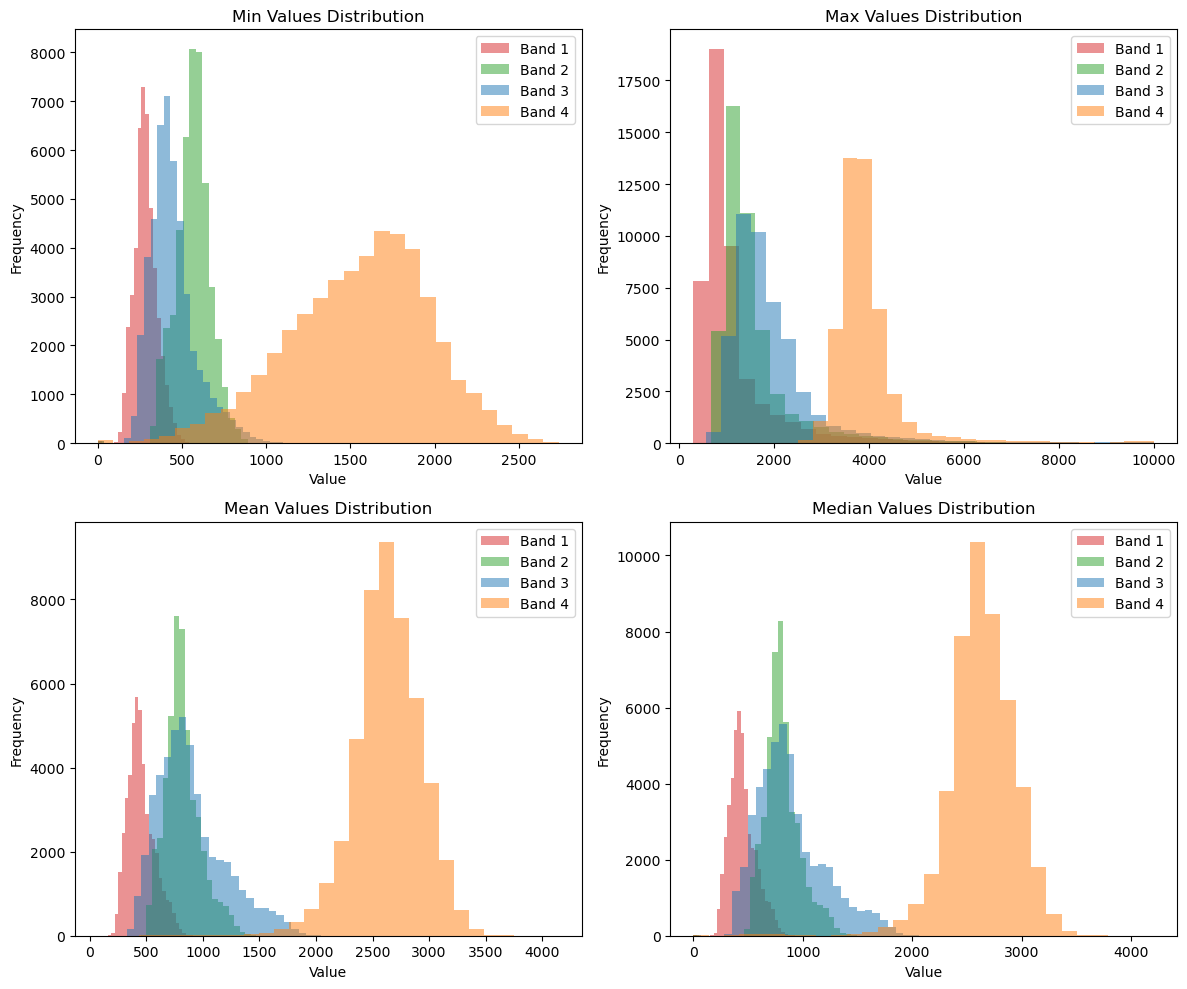

In [3]:
df = pd.DataFrame(shapes)

# Create 2x2 grid of histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

stats_to_plot = ["min", "max", "mean", "median"]
colors = [
    "#d62728",
    "#2ca02c",
    "#1f77b4",
    "#ff7f0e",
]  # Different color for each band

for idx, stat in enumerate(stats_to_plot):
    for band in range(4):
        column = f"band_{band + 1}_{stat}"
        axes[idx].hist(
            df[column], alpha=0.5, color=colors[band], label=f"Band {band + 1}", bins=30
        )

    axes[idx].set_title(f"{stat.capitalize()} Values Distribution")
    axes[idx].set_xlabel("Value")
    axes[idx].set_ylabel("Frequency")
    axes[idx].legend()

plt.tight_layout()

plot_filename = "../../images/nicfi_pixel_histograms.png"
plt.savefig(plot_filename, dpi=300)

plt.show()